# Learned rules

In this notebook, we will evaluate what simple rules a model has learned.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from NegativeClassOptimization import ml
from NegativeClassOptimization import utils
from NegativeClassOptimization import preprocessing
from NegativeClassOptimization import config
from NegativeClassOptimization import search

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
df = utils.load_global_dataframe()

ag_pos = "3VRL"
ag_neg = "1ADQ"
df = df.loc[df["Antigen"].isin([ag_pos, ag_neg])].copy()
df = df.drop_duplicates(["Slide"])

N = 20000
df = df.sample(n=N, random_state=42)
df = df.sample(frac=1, random_state=42)

df_train = df.iloc[:int(N*0.8)]
df_test = df.iloc[int(N*0.8):]

In [3]:
train_data, test_data, train_loader, test_loader = preprocessing.preprocess_data_for_pytorch_binary(
    df_train_val=df_train,
    df_test_closed=df_test,
    ag_pos=[ag_pos],
    batch_size=32,
    scale_onehot=False,
)

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


In [4]:
model = ml.SN10()
model = model.to("cpu")

learning_rate = 0.01
epochs = 15
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    ml.train_loop(train_loader, model, loss_fn, optimizer)
    ml.test_loop(test_loader, model, loss_fn)

Epoch 1
-------------------------------
loss: 0.689799  [    0/16000]
loss: 0.668173  [ 3200/16000]
loss: 0.668434  [ 6400/16000]
loss: 0.646049  [ 9600/16000]
loss: 0.654849  [12800/16000]
Test Error: 
 Acc: 77.7 Avg loss: 0.613079 

Epoch 2
-------------------------------
loss: 0.609710  [    0/16000]
loss: 0.567024  [ 3200/16000]
loss: 0.587267  [ 6400/16000]
loss: 0.579108  [ 9600/16000]
loss: 0.489707  [12800/16000]
Test Error: 
 Acc: 80.0 Avg loss: 0.498520 

Epoch 3
-------------------------------
loss: 0.470027  [    0/16000]
loss: 0.518171  [ 3200/16000]
loss: 0.381633  [ 6400/16000]
loss: 0.445776  [ 9600/16000]
loss: 0.273702  [12800/16000]
Test Error: 
 Acc: 81.6 Avg loss: 0.436325 

Epoch 4
-------------------------------
loss: 0.387257  [    0/16000]
loss: 0.504428  [ 3200/16000]
loss: 0.401459  [ 6400/16000]
loss: 0.422335  [ 9600/16000]
loss: 0.583090  [12800/16000]
Test Error: 
 Acc: 83.0 Avg loss: 0.405766 

Epoch 5
-------------------------------
loss: 0.438478  [   

## Mine simple rules

In [5]:
slides = df["Slide"].unique().tolist()

# 1 amino acid
motifs_1 = set([])
for slide in slides:
    for i, aa in enumerate(slide):
        motif = "."*i + aa + "."*(11-i-1)
        motifs_1.add(motif)
print(f"# 1-motifs: {len(motifs_1)}")

# 2 amino acids
motifs_2 = set([])
for slide in slides:
    for i, aa_i in enumerate(slide):
        for x, aa_j in enumerate(slide[i+1:]):
            j = x+i+1
            motif = "."*(i) + aa_i + "."*x + aa_j + "."*(11-j-1)
            motifs_2.add(motif)
print(f"# 2-motifs: {len(motifs_2)} | max = {45*20*20}")

# 3 amino acids
# TODO

# 1-motifs: 219
# 2-motifs: 17256 | max = 18000


In [6]:
# list(filter(lambda x: x[0] != ".", motifs_1))
# list(filter(lambda x: x[-1] != ".", motifs_1))
# list(filter(lambda x: x[0] != ".", motifs_2))
# list(filter(lambda x: x[-1] != ".", motifs_2))

In [7]:
df_train_ag_p = df_train.loc[df_train["Antigen"] == ag_pos]
df_train_ag_n = df_train.loc[df_train["Antigen"] == ag_neg]

N = df_train.shape[0]
N_ag_p = df_train_ag_p.shape[0]
N_ag_n = df_train_ag_n.shape[0]

def count_motifs(motifs, df_train_ag_p, df_train_ag_n):
    records = []
    for motif in motifs:
        M = df_train["Slide"].str.contains(pat=motif).sum()
        M_ag_p = df_train_ag_p["Slide"].str.contains(pat=motif).sum()
        M_ag_n = df_train_ag_n["Slide"].str.contains(pat=motif).sum()
        records.append({
        "motif": motif,
        "M": M,
        "M_ag_p": M_ag_p,
        "M_ag_n": M_ag_n,
    })        
    return pd.DataFrame.from_records(records)

df_1 = count_motifs(motifs_1, df_train_ag_p, df_train_ag_n)
df_1 = df_1.sort_values(by="M", ascending=False)
df_1.head()

,motif,M,M_ag_p,M_ag_n
208,.........Y.,7213,4634,2579
141,..........W,7128,4126,3002
154,.......F...,5916,3453,2463
56,C..........,5855,4505,1350
78,........D..,5490,2962,2528


In [8]:
df_1["acc_int"] = df_1[["M_ag_p", "M_ag_n"]].apply(max, axis=1) / df_1["M"]
df_1["diff"] = abs(df_1["M_ag_p"] - df_1["M_ag_n"])

# df_1.sort_values(["acc_int", "M"], ascending=[False, False]).head(20)
df_1 = df_1.sort_values(by="diff", ascending=False)
df_1.head(20)

,motif,M,M_ag_p,M_ag_n,acc_int,diff
56,C..........,5855,4505,1350,0.769428,3155
59,.A.........,4767,3821,946,0.801552,2875
80,..R........,4515,3454,1061,0.765006,2393
108,.L.........,3356,540,2816,0.839094,2276
1,......L....,4261,3216,1045,0.754752,2171
208,.........Y.,7213,4634,2579,0.642451,2055
65,.......L...,3778,2758,1020,0.730016,1738
121,..L........,2400,354,2046,0.852500,1692
105,.....L.....,5432,3356,2076,0.617820,1280
152,.........D.,1283,76,1207,0.940764,1131


<AxesSubplot:>

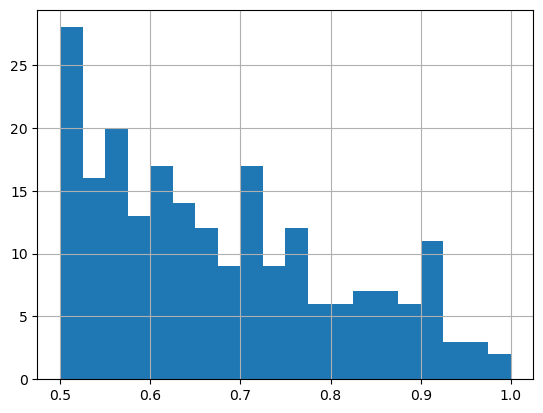

In [9]:
df_1["acc_int"].hist(bins=20)

Faster version

In [10]:
def record_motif(motifs, ag, motif):
    if motif not in motifs:
        motifs[motif] = {"M": 0, "M_p": 0, "M_n": 0}
    motifs[motif]["M"] += 1
    if ag == ag_pos:
        motifs[motif]["M_p"] += 1
    else:
        motifs[motif]["M_n"] += 1
    return motifs


motifs = {}
for i, row in df_train.iterrows():
    ag = row["Antigen"]
    slide = row["Slide"]
    
    # 1-motifs
    for i, aa in enumerate(slide):
        motif = "."*i + aa + "."*(11-i-1)    
        motifs = record_motif(motifs, ag, motif)
    
    # 2-motifs
    for i, aa_i in enumerate(slide):
        for x, aa_j in enumerate(slide[i+1:]):
            j = x+i+1
            motif = "."*(i) + aa_i + "."*x + aa_j + "."*(11-j-1)
            motifs = record_motif(motifs, ag, motif)

    # 3 amino acids
    # TODO

In [11]:
df_motifs = pd.DataFrame.from_dict(motifs, orient='index')
df_motifs = df_motifs.reset_index().rename(columns={"index": "motif"})
df_motifs["is_motif_1"] = df_motifs["motif"].str.count("\.") == 10
df_motifs["is_motif_2"] = df_motifs["motif"].str.count("\.") == 9

df_motifs["acc_int"] = df_motifs[["M_p", "M_n"]].apply(max, axis=1) / df_motifs["M"]
df_motifs["acc"] = ( df_motifs["acc_int"] * df_motifs["M"] + 0.5 * (N - df_motifs["M"]) ) / N

df_motifs["diff"] = abs(df_motifs["M_p"] - df_motifs["M_n"])

df_motifs = df_motifs.sort_values(by="acc", ascending=False)

df_motifs.head(30)

,motif,M,M_p,M_n,is_motif_1,is_motif_2,acc_int,acc,diff
188,C..........,5855,4505,1350,True,False,0.769428,0.598594,3155
189,.A.........,4767,3821,946,True,False,0.801552,0.589844,2875
196,CA.........,4519,3642,877,False,True,0.805931,0.586406,2765
197,C.R........,3807,3141,666,False,True,0.825059,0.577344,2475
190,..R........,4515,3454,1061,True,False,0.765006,0.574781,2393
1,.L.........,3356,540,2816,True,False,0.839094,0.571125,2276
206,.AR........,3362,2812,550,False,True,0.836407,0.570688,2262
811,......L....,4261,3216,1045,True,False,0.754752,0.567844,2171
366,C........Y.,2797,2452,345,False,True,0.876654,0.565844,2107
257,.........Y.,7213,4634,2579,True,False,0.642451,0.564219,2055


<AxesSubplot:xlabel='M', ylabel='acc_int'>

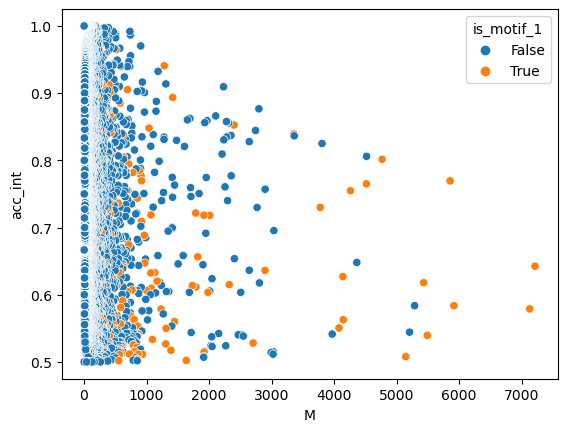

In [12]:
sns.scatterplot(data=df_motifs, x="M", y="acc_int", hue="is_motif_1")

Evaluate model on rule set

In [13]:
df_motifs_sel = df_motifs.loc[(df_motifs["M"] >= 500) & (df_motifs["acc_int"] >= 0.85)].copy()
print(df_motifs_sel.shape)
df_motifs_sel.head(20)

(51, 9)


,motif,M,M_p,M_n,is_motif_1,is_motif_2,acc_int,acc,diff
366,C........Y.,2797,2452,345,False,True,0.876654,0.565844,2107
375,.A.......Y.,2231,2029,202,False,True,0.909458,0.557094,1827
2,..L........,2400,354,2046,True,False,0.852500,0.552875,1692
823,.A....L....,2313,1979,334,False,True,0.855599,0.551406,1645
829,..R...L....,2283,1957,326,False,True,0.857205,0.550969,1631
850,......LL...,2278,1954,324,False,True,0.857770,0.550937,1630
458,..R......Y.,2106,1824,282,False,True,0.866097,0.548188,1542
452,.A........F,1966,1689,277,False,True,0.859105,0.544125,1412
459,..R.......F,1931,1653,278,False,True,0.856033,0.542969,1375
367,C.........W,1693,1460,233,False,True,0.862374,0.538344,1227


In [14]:
metrics_on_motifs = {}

for motif in df_motifs_sel["motif"]:
    df_train_m = df_train.loc[df_train["Slide"].str.contains(pat=motif)].copy()
    _, _, train_m_loader, _ = preprocessing.preprocess_data_for_pytorch_binary(
        df_train_val=df_train_m,
        df_test_closed=df_test,
        ag_pos=[ag_pos],
        batch_size=32,
        scale_onehot=False,
    )
    metrics = ml.test_loop(train_m_loader, model, loss_fn)
    metrics_on_motifs[motif] = metrics

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 89.0 Avg loss: 0.314732 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 90.9 Avg loss: 0.281480 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 89.8 Avg loss: 0.263808 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 89.9 Avg loss: 0.292486 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 89.4 Avg loss: 0.305303 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 88.6 Avg loss: 0.321996 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 89.5 Avg loss: 0.315642 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 86.9 Avg loss: 0.331974 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 86.6 Avg loss: 0.336164 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 88.1 Avg loss: 0.323923 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 87.1 Avg loss: 0.353516 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 97.0 Avg loss: 0.110119 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 95.1 Avg loss: 0.146579 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 91.1 Avg loss: 0.273356 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 92.7 Avg loss: 0.208719 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 91.1 Avg loss: 0.241436 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 88.9 Avg loss: 0.322598 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 98.1 Avg loss: 0.083850 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 92.7 Avg loss: 0.220566 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 91.6 Avg loss: 0.230855 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 92.6 Avg loss: 0.192630 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 98.9 Avg loss: 0.065513 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 99.2 Avg loss: 0.060300 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 90.8 Avg loss: 0.251487 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 89.9 Avg loss: 0.289926 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 95.6 Avg loss: 0.146992 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 95.1 Avg loss: 0.165352 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 96.8 Avg loss: 0.118997 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 95.0 Avg loss: 0.157803 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 87.6 Avg loss: 0.288173 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 95.6 Avg loss: 0.145829 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 93.5 Avg loss: 0.219503 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 91.1 Avg loss: 0.245316 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 96.5 Avg loss: 0.146056 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 96.4 Avg loss: 0.136833 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 92.6 Avg loss: 0.203134 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 94.4 Avg loss: 0.174269 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 98.6 Avg loss: 0.038579 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 99.0 Avg loss: 0.076662 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 98.8 Avg loss: 0.085731 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 90.8 Avg loss: 0.242921 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 93.0 Avg loss: 0.210001 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 95.3 Avg loss: 0.136589 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 98.4 Avg loss: 0.078345 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 95.6 Avg loss: 0.152702 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 87.3 Avg loss: 0.267454 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 91.8 Avg loss: 0.174982 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 91.9 Avg loss: 0.215510 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 90.8 Avg loss: 0.235844 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 94.4 Avg loss: 0.193170 



/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


Test Error: 
 Acc: 88.1 Avg loss: 0.231264 



In [15]:
for motif in metrics_on_motifs.keys():
    sn10_acc = metrics_on_motifs[motif]["acc_closed"]
    df_motifs_sel.loc[df_motifs_sel["motif"] == motif, "sn10_acc"] = sn10_acc

In [16]:
df_motifs_sel["acc_diff"] = df_motifs_sel["acc_int"] - df_motifs_sel["sn10_acc"]
df_motifs_sel.sort_values(by="acc_diff", ascending=False).head(20)

,motif,M,M_p,M_n,is_motif_1,is_motif_2,acc_int,acc,diff,sn10_acc,acc_diff
488,..........D,696,66,630,True,False,0.905172,0.517625,564,0.876437,0.028736
21,.LL........,1184,80,1104,False,True,0.932432,0.532000,1024,0.926520,0.005912
1027,.A......D..,851,768,83,False,True,0.902468,0.521406,685,0.898942,0.003525
376,.A........W,1309,1196,113,False,True,0.913675,0.533844,1083,0.911383,0.002292
88,.L........Y,505,6,499,False,True,0.988119,0.515406,493,0.986139,0.001980
106,....L....D.,572,19,553,False,True,0.966783,0.516687,534,0.965035,0.001748
2012,.A...W.....,744,711,33,False,True,0.955645,0.521188,678,0.955645,0.000000
61,.......Y.D.,734,6,728,False,True,0.991826,0.522563,722,0.991826,0.000000
375,.A.......Y.,2231,2029,202,False,True,0.909458,0.557094,1827,0.909458,0.000000
1462,....L...F..,567,33,534,False,True,0.941799,0.515656,501,0.943563,-0.001764


(0.85, 1.0)

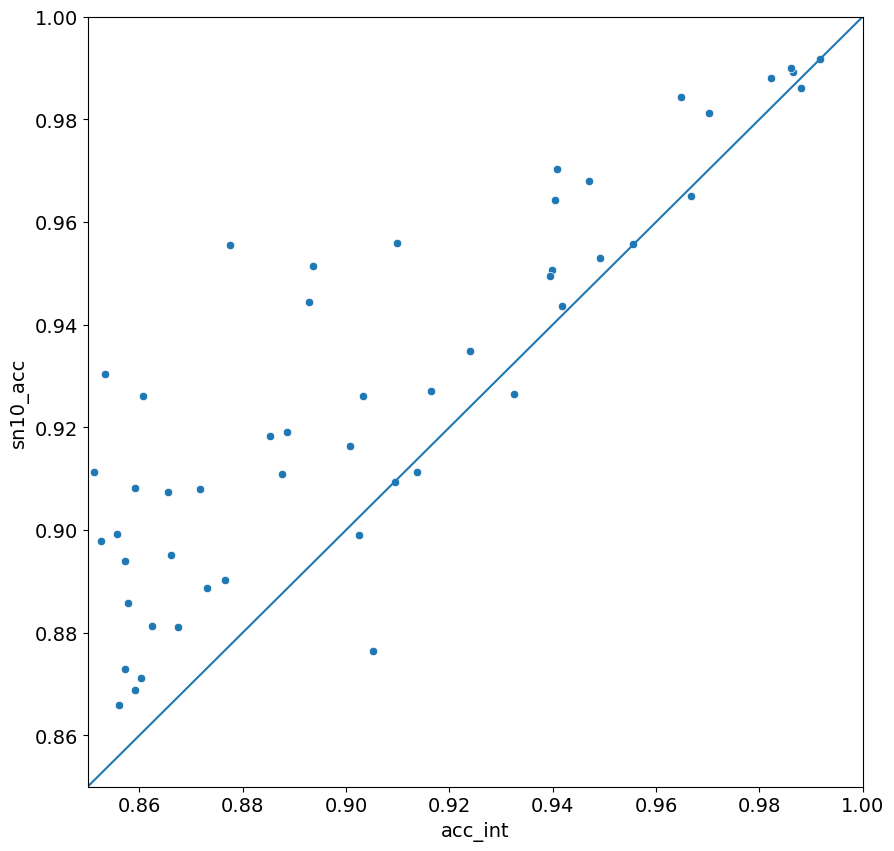

In [23]:
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df_motifs_sel, x="acc_int", y="sn10_acc")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
ax.set_xlim(0.85, 1)
ax.set_ylim(0.85, 1)

## Mine complex rules

In [18]:
BEAM_B = 10
BEAM_N = 10

In [19]:
def promote_motifs(df_motifs_i, num_motifs=BEAM_B):
    
    # (1)
    # motifs_promoted = df_motifs_i.head(BEAM_B)["motif"].tolist()

    # (2)
    df_ = df_motifs_i.loc[df_motifs_i["acc_int"] > 0.90].copy().sort_values("M", ascending=False)
    motifs_promoted = df_.head(num_motifs)["motif"].tolist()
    motifs_promoted = [search.Motif.init_from_regex(m) for m in motifs_promoted]
    return motifs_promoted

In [20]:
# Build base motifs
from typing import List


base_motifs = []
for i in range(11):
    for aa in config.AMINOACID_ALPHABET:
        motif = "."*i + aa + "."*(10-i)
        motif: List[str] = list(motif)
        base_motifs.append(search.Motif(motif))

# Evaluate base motifs
df_motifs = search.evaluate_motifs(base_motifs, df_train, ag_pos)
df_motifs["beam_round"] = 0

# Beam search
df_motifs_i = df_motifs.copy()
for i in range(BEAM_N):
    print(f"Beam round: {i+1}")
    motifs_promoted = promote_motifs(df_motifs_i)
    
    if len(motifs_promoted) == 0:
        print("No more motifs to promote.")
        break

    motifs_i = search.develop_motifs(motifs_promoted, base_motifs)
    
    df_motifs_i = search.evaluate_motifs(motifs_i, df_train, ag_pos)
    df_motifs_i["beam_round"] = i+1
    df_motifs = pd.concat([df_motifs, df_motifs_i], axis=0)

    print(df_motifs_i.loc[df_motifs_i["acc_int"] > 0.90].sort_values("M", ascending=False).head(30))

Beam round: 1
               motif     M  M_p   M_n   acc_int       acc  beam_round
1284  ........[FM]..  1664  160  1504  0.903846  0.542000           1
1011  .........[DM].  1456  103  1353  0.929258  0.539062           1
1594  .........[DH].  1376  131  1245  0.904797  0.534813           1
624   .........[DI].  1352  122  1230  0.909763  0.534625           1
1142  .........[DN].  1334  107  1227  0.919790  0.535000           1
1983  .........[CD].  1317  102  1215  0.922551  0.534781           1
1407  .........[DQ].  1293   85  1208  0.934261  0.535094           1
1497  .........[DE].  1291   82  1209  0.936483  0.535219           1
900   .........[DK].  1286   77  1209  0.940124  0.535375           1
1608  .....[DT].....   927   59   868  0.936354  0.525281           1
178   .....[DS].....   911   53   858  0.941822  0.525156           1
770      ........FD.   907   27   880  0.970232  0.526656           1
188   .....[ST].....   816   76   740  0.906863  0.520750           1
1442  

KeyboardInterrupt: 

<AxesSubplot:xlabel='beam_round', ylabel='M'>

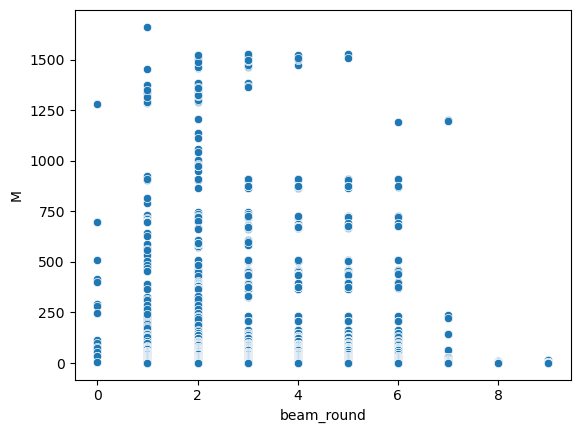

In [ ]:
sns.scatterplot(
    data=df_motifs.loc[df_motifs["acc_int"] > 0.90],
    x="beam_round",
    y="M",
)

In [ ]:
df_motifs.loc[(df_motifs["acc_int"] > 0.90) & (df_motifs["M"] >= 1200)].sort_values("beam_round", ascending=False).head(20)

,motif,M,M_p,M_n,acc_int,acc,beam_round
692,.......Y[DEFKMNQ].,1202,94,1108,0.921797,0.531687,7
128,.........[CDEKMQ].,1511,145,1366,0.904037,0.538156,5
1780,.........[DEKMNQ].,1528,150,1378,0.901832,0.538375,5
1544,.........[CDEKM].,1501,136,1365,0.909394,0.538406,4
1136,.........[DEKMQ].,1477,119,1358,0.919431,0.538719,4
576,.........[DEKMN].,1518,141,1377,0.907115,0.538625,4
2126,.........[DKMNQ].,1520,144,1376,0.905263,0.538500,4
1735,.........[DEMNQ].,1525,149,1376,0.902295,0.538344,4
1032,.........[CDKMQ].,1503,139,1364,0.907518,0.538281,4
204,.........[CDEMQ].,1508,144,1364,0.904509,0.538125,4


In [ ]:
"".join(sorted(set(["A", "B", "C"])))

'ABC'

In [ ]:
df_motifs.sort_values("acc_int", ascending=False).head(4000).tail(20)

,motif,M,M_p,M_n,acc_int,acc,beam_round
1914,........[FM].V,505,7,498,0.986139,0.515344,2
915,.....R....D,142,2,140,0.985915,0.504313,1
219,...L....M..,138,2,136,0.985507,0.504188,1
1179,.F......[FM]..,68,1,67,0.985294,0.502062,2
166,.W......[FM]..,68,1,67,0.985294,0.502062,2
1459,.......Y.[DH].,743,11,732,0.985195,0.522531,2
438,.......Y.[DHK].,743,11,732,0.985195,0.522531,3
1601,....T....[DMN].,67,1,66,0.985075,0.502031,3
1427,....F....[DIQ].,67,1,66,0.985075,0.502031,3
32,.W.......[CDEKMQ].,67,1,66,0.985075,0.502031,6


<AxesSubplot:xlabel='M', ylabel='acc_int'>

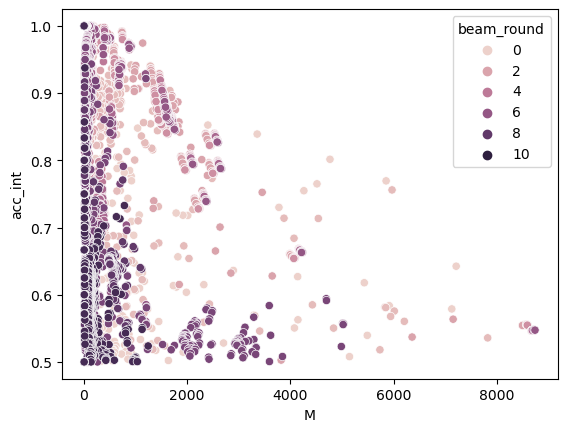

In [ ]:
sns.scatterplot(data=df_motifs, x="M", y="acc_int", hue="beam_round")

### script_10 run #1

Results appear strange, because most stack amino acids into the same places. May require a change in optimization objective or may imply a bug in the code for generating new motifs or selecting for further rounds.

In [ ]:
res_dir = Path("../data/BeamRules/beam_results")
df = pd.read_csv(res_dir / "beam_200.csv")
df.head(10)

,motif,M,M_p,M_n,acc_int,acc,beam_round
0,.[ACDEGHPRST].........,8614,6138,2476,0.712561,0.591550,200
1,.[ACDGHPRST].........,8427,6044,2383,0.717218,0.591525,200
2,.[ADEGHPRST].........,8569,6114,2455,0.713502,0.591475,200
3,.[ADGHPRST].........,8382,6020,2362,0.718206,0.591450,200
4,.[ACEGHPRST].........,8467,6059,2408,0.715602,0.591275,200
5,.[ACGHPRST].........,8280,5965,2315,0.720411,0.591250,200
6,.[ACDEGHNPRST].........,8680,6165,2515,0.710253,0.591250,200
7,.[ACDGHNPRST].........,8493,6071,2422,0.714824,0.591225,200
8,.[AEGHPRST].........,8422,6035,2387,0.716576,0.591200,200
9,.[ADEGHNPRST].........,8635,6141,2494,0.711175,0.591175,200


In [ ]:
df["motif"].str.count("\.").value_counts()

9     20000
10      793
Name: motif, dtype: int64

<AxesSubplot:xlabel='M', ylabel='acc_int'>

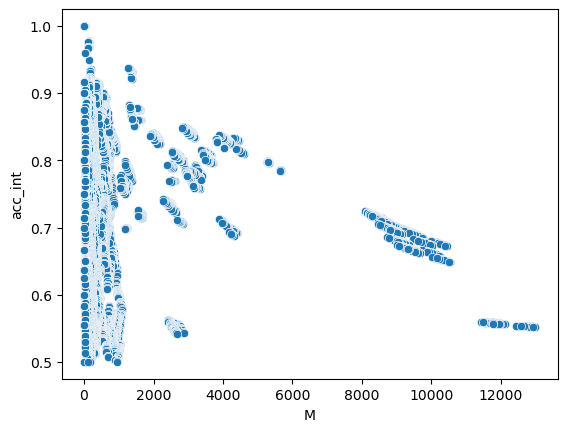

In [ ]:
sns.scatterplot(data=df, x="M", y="acc_int")

In [ ]:
df.loc[(df["M"] > 1000) & (df["acc_int"] > 0.90)].sort_values("acc_int", ascending=False).head(50)

,motif,M,M_p,M_n,acc_int,acc,beam_round
1987,.[AGPRST]...W.....,1274,1195,79,0.937991,0.527900,200
1981,.[ADGHRST]...W.....,1282,1202,80,0.937598,0.528050,200
1980,.[ACGPRST]...W.....,1282,1202,80,0.937598,0.528050,200
1964,.[AGHPRST]...W.....,1294,1213,81,0.937403,0.528300,200
1973,.[ACDGHRST]...W.....,1290,1209,81,0.937209,0.528200,200
1955,.[ACGHPRST]...W.....,1302,1220,82,0.937020,0.528450,200
1978,.[ADGHPRT]...W.....,1285,1204,81,0.936965,0.528075,200
1970,.[ACDGHPRT]...W.....,1293,1211,82,0.936582,0.528225,200
1961,.[AEGPRST]...W.....,1301,1218,83,0.936203,0.528375,200
1941,.[AGHNPRST]...W.....,1310,1226,84,0.935878,0.528550,200


## Rules in missclassified examples

In [ ]:
from NegativeClassOptimization import datasets
from torch.utils.data import DataLoader

encoder = preprocessing.get_one_hot_aa_encoder()

X, y = ml.Xy_from_loader(train_loader)

miss_mask = (model.forward(X).round() != y)
X_miss = X[miss_mask]
slides_miss = []
for X_i in X_miss:
    l = encoder.inverse_transform(X_i.reshape(11, 20)).reshape(-1).tolist()
    slide = "".join(l)
    slides_miss.append(slide)
print(len(slides_miss))

2190


In [ ]:
df_miss = df_train.loc[df_train["Slide"].isin(slides_miss)].copy()
df_miss

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,UID,Antigen
8893,645466_00a,CARLRLRLEVYAMDYW,True,CARLRLRLEVY,-95.69,137248-RRDLDUDRDR,1ADQ_645466_00a,1ADQ
11145,297740_02a,CACLGFHWYFDVW,True,CLGFHWYFDVW,-102.15,128928-SRURUDULUR,1ADQ_297740_02a,1ADQ
399799,6466474_03a,CARLFPMIRTLTGYFDVW,True,LFPMIRTLTGY,-96.96,137442-BRDSLLUDLS,3VRL_6466474_03a,3VRL
7972,3233955_00a,CARFLLLTCDYW,True,CARFLLLTCDY,-94.48,132966-BDRSUUSLUL,1ADQ_3233955_00a,1ADQ
6379,3994113_00a,CAFLYDYGWYFDVW,True,CAFLYDYGWYF,-97.90,128868-LSRRLLSUSU,1ADQ_3994113_00a,1ADQ
...,...,...,...,...,...,...,...,...
405658,1145996_06a,CARWGKRLYDYFLFAYW,True,RLYDYFLFAYW,-98.12,137375-SLSDSRRSDL,3VRL_1145996_06a,3VRL
38421,813087_03a,CARWGGWLLLFDYW,True,WGGWLLLFDYW,-97.73,124837-RRURSUUSLD,1ADQ_813087_03a,1ADQ
365990,554353_01a,CALYDGYYLGFFAYW,True,ALYDGYYLGFF,-96.60,137375-SLSDSRRSDL,3VRL_554353_01a,3VRL
22613,4867431_03a,CTTLILLGIFFDYW,True,LILLGIFFDYW,-94.44,132961-DLDDLLURUU,1ADQ_4867431_03a,1ADQ


In [ ]:
df_miss["Antigen"].value_counts()

1ADQ    1372
3VRL     818
Name: Antigen, dtype: int64

In [ ]:
# Build base motifs
from typing import List


base_motifs = []
for i in range(11):
    for aa in config.AMINOACID_ALPHABET:
        motif = "."*i + aa + "."*(10-i)
        motif: List[str] = list(motif)
        base_motifs.append(search.Motif(motif))

# Evaluate base motifs
df_motifs = search.evaluate_motifs(base_motifs, df_miss, ag_pos)
df_motifs["beam_round"] = 0

# Beam search
df_motifs_i = df_motifs.copy()
for i in range(BEAM_N):
    print(f"Beam round: {i+1}")
    motifs_promoted = promote_motifs(df_motifs_i)
    
    if len(motifs_promoted) == 0:
        print("No more motifs to promote.")
        break

    motifs_i = search.develop_motifs(motifs_promoted, base_motifs)
    
    df_motifs_i = search.evaluate_motifs(motifs_i, df_miss, ag_pos)
    df_motifs_i["beam_round"] = i+1
    df_motifs = pd.concat([df_motifs, df_motifs_i], axis=0)

    print(df_motifs_i.loc[df_motifs_i["acc_int"] > 0.90].sort_values("M", ascending=False).head(30))

Beam round: 1
               motif   M  M_p  M_n   acc_int       acc  beam_round
399   ...[HQ].......  52    5   47  0.903846  0.509589           1
241      ...Q...L...  19    1   18  0.947368  0.503881           1
1806     ...Q..L....  16    1   15  0.937500  0.503196           1
165      ...Q......F  16    1   15  0.937500  0.503196           1
49       ...Q.....Y.  14    1   13  0.928571  0.502740           1
205      C..Q.......  14    0   14  1.000000  0.503196           1
734   .........[IK].  13    1   12  0.923077  0.502511           1
1923  .....[AE].....  12    0   12  1.000000  0.502740           1
718   .........[IQ].  12    1   11  0.916667  0.502283           1
1784  .....[AK].....  12    0   12  1.000000  0.502740           1
1201     ...Q.L.....  11    0   11  1.000000  0.502511           1
147      C........I.  11    0   11  1.000000  0.502511           1
1259  .....[AC].....  11    1   10  0.909091  0.502055           1
1223     .A.......I.  10    0   10  1.000000  0.

<AxesSubplot:xlabel='M', ylabel='acc_int'>

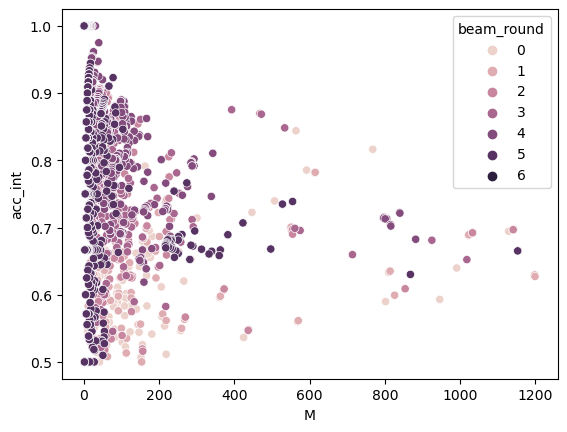

In [ ]:
sns.scatterplot(data=df_motifs, x="M", y="acc_int", hue="beam_round")

In [ ]:
df_motifs.loc[(df_motifs["acc_int"] > 0.9)].sort_values("M", ascending=False).head(20)

,motif,M,M_p,M_n,acc_int,acc,beam_round
906,C.[HQR][LP]...,78,6,72,0.923077,0.515068,5
853,C.[HKQR]L...,67,6,61,0.910448,0.512557,5
1231,...[FHQ]..L...,67,6,61,0.910448,0.512557,3
399,...[HQ].......,52,5,47,0.903846,0.509589,1
79,...[HKQ]..L...,51,5,46,0.901961,0.509361,3
672,C..[FHQ].L...,50,4,46,0.920000,0.509589,4
864,...[HQ]..[IL]...,43,4,39,0.906977,0.507991,3
218,...[HQ]..[LR]...,43,4,39,0.906977,0.507991,3
296,...[HQ]..[LQ]...,43,4,39,0.906977,0.507991,3
391,...[HQ]..[CL]...,43,4,39,0.906977,0.507991,3
